# LSTM

In [1]:
import os
from numpy import concatenate
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib import pyplot
import seaborn as sns
from math import sqrt

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima_model import ARIMA 

py.init_notebook_mode(True)

Using TensorFlow backend.
/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [2]:
path = "/Users/az02210/Documents/Python/BitCoinPrediction/data/converged/merged.csv"
df = pd.read_csv(path)

In [3]:
df.dropna(axis=1, how="all")
df["stamp"] = pd.to_datetime(df["stamp"].apply(str), format="%Y%m%d")

In [4]:
def show_price_evolution(df):
    btc_trace = go.Scatter(x=df['stamp'], y=df["price"], name="Price")
    py.iplot([btc_trace])

In [5]:
show_price_evolution(df)

In [6]:
df["price"].replace(0, np.nan, inplace=True)
df["price"].fillna(method="ffill", inplace=True)

In [7]:
show_price_evolution(df)

In [8]:
def scale(df):
    values = df["price"].values.reshape(-1, 1)
    values = values.astype("float32")
    scaler = MinMaxScaler(feature_range=(0, 1))

    return scaler.fit_transform(values), scaler

In [9]:
scaled, scaler = scale(df)
sentiment = df["sentiment"].values.reshape(-1, 1).astype("float32")

In [10]:
def split_data(scaled):
    train_size = int(len(scaled) * 0.65)
    test_size = len(scaled) - train_size
    train, test = scaled[0: train_size, :], scaled[train_size:, :]

    return train, test, train_size

In [11]:
def create_dataset(dataset, look_back, sentiment):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        res = dataset[i: (i + look_back), 0]
        np.append(res, sentiment[i])
        dataX.append(res)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [12]:
train, test, train_size = split_data(scaled)
trainX, trainY = create_dataset(train, 1, sentiment[0: train_size])
testX, testY = create_dataset(test, 1, sentiment[train_size:])

In [13]:
def reshape_X(df):
    return np.reshape(df, (df.shape[0], 1, df.shape[1]))

In [14]:
trainX = reshape_X(trainX)
testX = reshape_X(testX)

In [15]:
def build_model(trainX):
    model = Sequential()
    model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(1))
    model.compile(loss="mae", optimizer="adam")

    return model

In [16]:
model = build_model(trainX)
history = model.fit(trainX, trainY, epochs=150, batch_size = 64, validation_data=(testX, testY), verbose=0, shuffle=False)

In [17]:
def show_val_loss(history):
    train = go.Scatter(y = history.history["loss"], name="train")
    test = go.Scatter(y = history.history["val_loss"], name="test")
    py.iplot([train, test])

In [18]:
show_val_loss(history)

In [19]:
def show_pred_real(real, pred):
    real = pd.DataFrame(real, columns=["real"])
    pred = pd.DataFrame(pred, columns=["pred"])
    x = go.Scatter(y = real["real"], name="real")
    y = go.Scatter(y = pred["pred"], name="pred")
    py.iplot([x, y])

In [20]:
pred = model.predict(testX)

In [21]:
show_pred_real(testY, pred)

In [22]:
def inverse_scale(scaler, val):
    return scaler.inverse_transform(val.reshape(-1, 1))

In [23]:
pred_inv = inverse_scale(scaler, pred)
real_inv = inverse_scale(scaler, testX)

In [24]:
rmse = sqrt(mean_squared_error(real_inv, pred_inv))
print("RMSE: ", rmse)

RMSE:  9.277751635770331


In [25]:
show_pred_real(real_inv, pred_inv)

In [26]:
def reshape_Y(df):
    return df.reshape(len(df))

In [27]:
predDates = df.tail(len(testX))["stamp"]
real_inv_resh = reshape_Y(real_inv)
pred_inv_resh = reshape_Y(pred_inv)

In [28]:
def show_by_date(predDates, real, pred):
    """."""
    actual = go.Scatter(x=predDates, y=real, name="Actual")
    pred = go.Scatter(x=predDates, y=pred, name="Pred")
    py.iplot([pred, actual])

In [29]:
show_by_date(predDates, real_inv_resh, pred_inv_resh)

In [30]:
def show_corr(df):
    data = go.Heatmap(
        z=df.corr().values.tolist(),
        x=list(df.corr().columns),
        y=list(df.corr().index),
        colorscale='Viridis'
    )
    py.iplot([data])  

In [31]:
show_corr(df)

In [32]:
scaled, scaler = scale(df)

In [33]:
def series_to_supervised(scaled):
    df_scaled = pd.DataFrame(scaled, columns=["var1(t-1)"])
    df_scaled["var1(t)"] = df_scaled.shift(-1)
    
    return df_scaled.dropna()

In [34]:
reframed = series_to_supervised(scaled)

In [35]:
train, test, train_size = split_data(reframed.values)

In [36]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [37]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [38]:
multi_model = build_model(train_X)
multi_history = multi_model.fit(train_X, train_y, epochs=150, batch_size = 64, validation_data=(testX, testY), verbose=0, shuffle=False)

In [39]:
show_val_loss(multi_history)

In [40]:
multi_pred = multi_model.predict(test_X)

In [41]:
show_pred_real(test_y, multi_pred)

In [42]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
inv_multi_pred = np.concatenate((multi_pred, test_X[:, 1:]), axis=1)
inv_multi_pred = scaler.inverse_transform(inv_multi_pred)
inv_multi_pred = inv_multi_pred[:,0]

In [43]:
test_y = test_y.reshape((len(test_y), 1))
inv_multi_real = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_multi_real = scaler.inverse_transform(inv_multi_real)
inv_multi_real = inv_multi_real[:,0]

In [44]:
rmse = sqrt(mean_squared_error(inv_multi_real, inv_multi_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.237


In [45]:
actual_chart = go.Scatter(x=predDates, y=inv_multi_real, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predDates, y=inv_multi_pred, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predDates, y=pred_inv_resh, name= 'Predict Price')
py.iplot([predict_chart, multi_predict_chart, actual_chart])

In [46]:
reframed["sentiment"] = df["sentiment"].head(-1)

In [47]:
train, test, train_size = split_data(reframed.values)

In [48]:
def create_dataset(dataset, look_back, sentiment, sent=False):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        if i >= look_back:
            a = dataset[i-look_back:i+1, 0]
            a = a.tolist()
            if(sent==True):
                a.append(sentiment[i].tolist()[0])
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [49]:
look_back = 1
trainX, trainY = create_dataset(train, look_back, sentiment[:train_size],sent=True)
testX, testY = create_dataset(test, look_back, sentiment[train_size:], sent=True)

In [50]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [51]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [52]:
show_val_loss(history)

In [53]:
pred = model.predict(testX)

In [54]:
show_pred_real(testY, pred)

In [55]:
pred_inverse_sent = scaler.inverse_transform(pred.reshape(-1, 1))
testY_inverse_sent = scaler.inverse_transform(testY.reshape(-1, 1))

In [56]:
rmse_sent = sqrt(mean_squared_error(testY_inverse_sent, pred_inverse_sent))
print('Test RMSE: %.3f' % rmse_sent)

Test RMSE: 17.480


In [57]:
a = pd.DataFrame(pred_inverse_sent, columns=["a"])
b = pd.DataFrame(testY_inverse_sent, columns=["a"])
actual_chart = go.Scatter(x=predDates, y=a["a"], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predDates, y=b["a"], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])

# ARIMA

In [58]:
path1 = "/Users/az02210/Documents/Python/BitCoinPrediction/data/raw/bitcoin.csv"
df1 = pd.read_csv(path1)

In [59]:
show_price_evolution(df1)
df1.set_index("stamp", inplace=True)

In [60]:
def build_arima_model(df):
    model = ARIMA(df, order=(5,1,0))
    
    return model.fit(disp=0)

In [61]:
arima_mdl = build_arima_model(df1)
print(arima_mdl.summary())

/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  742
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5321.615
Method:                       css-mle   S.D. of innovations            315.107
Date:                Sun, 11 Feb 2018   AIC                          10657.230
Time:                        00:28:35   BIC                          10689.495
Sample:                    01-29-2016   HQIC                         10669.668
                         - 02-08-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             9.3361     14.310      0.652      0.514     -18.711      37.384
ar.L1.D.price     0.1206      0.036      3.342      0.001       0.050       0.191
ar.L2.D.price    -0.0781      0.036     

/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



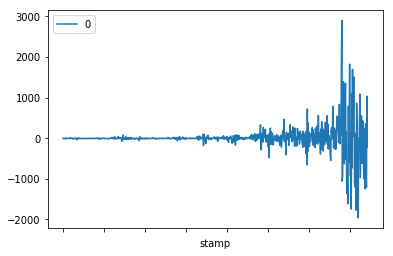

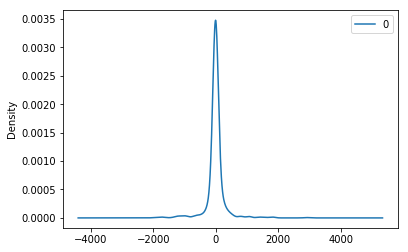

                 0
count   742.000000
mean      0.007494
std     315.319179
min   -1964.334269
25%     -17.173814
50%      -5.841653
75%      19.091014
max    2904.639116


In [62]:
residuals = pd.DataFrame(arima_mdl.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



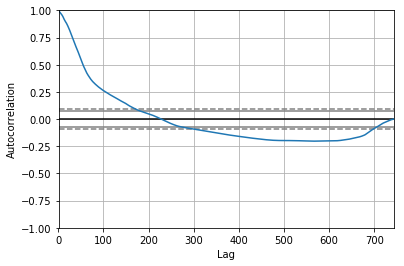

In [63]:
pd.tools.plotting.autocorrelation_plot(df1)
pyplot.show()

In [64]:
from tqdm import tqdm

X = df1.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
print('Total Test cases: {}'.format(len(test)))
for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

  0%|          | 0/253 [00:00<?, ?it/s]

Total Test cases: 253


/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.

/Users/az02210/anaconda3/envs/BitCoinPred/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

100%|██████████| 253/253 [00:19<00:00, 12.70it/s]


Test MSE: 582.737


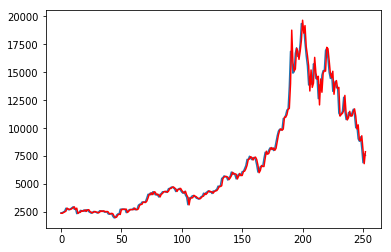

In [65]:
error = sqrt(mean_squared_error(test, predictions))
print('Test MSE: %.3f' % error)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()